In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='a321aafc-51b5-4008-aba2-9afa946f648e', project_access_token='p-e92fd8e33e0a36e826c7273ccf43ba951bb4e3cd')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 7 - BanCoppel

<hr>

## Instalando Librerias

In [ ]:
!pip install scikit-learn==0.23.2 --upgrade
!pip install pandas==1.1.1 --upgrade
!pip install seaborn==0.10.1 --upgrade
!pip install -U imbalanced-learn

<hr>

## Descargar los conjuntos de datos en formato .csv

In [2]:
import pandas as pd
import numpy as np

import itertools

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

import matplotlib.pyplot as plt

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
!wget --no-check-certificate --content-disposition https://gitlab.com/JoaoPedroPP/datasets/-/raw/master/training_dataset.csv
df_training_dataset = pd.read_csv(r'training_dataset.csv')
df_training_dataset.tail()

--2020-09-17 14:21:40--  https://gitlab.com/JoaoPedroPP/datasets/-/raw/master/training_dataset.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘training_dataset.csv.1’

    [ <=>                                   ] 2,327,419   --.-K/s   in 0.02s   

2020-09-17 14:21:40 (122 MB/s) - ‘training_dataset.csv.1’ saved [2327419]



ID Genero  Años Estado_civil           Trabajo               Sector  \
23994  160      F  40.0      Soltero          Profesor       Sector privado   
23995  155      F  24.0          NaN          Profesor  Institucion publica   
23996  229      F  24.0       Casado          Profesor         Desempleados   
23997  214      F  24.0      Soltero      Desempleados         Desempleados   
23998   30      M  30.0       Casado  Servidor publico  Institucion publica   

        Telefono  Anos_usando_internet_banking  Anos_usando_banca_movil  \
23994  Iphone 6+                          10.0                      3.0   
23995        L G                          15.0                      6.0   
23996     LG V10                           5.0                      3.0   
23997    Android                           5.0                      6.0   
23998          0                           5.0                      4.0   

      Banca_movil_userfriendly  Frecuencia_internet_banking_mes  \
23994                       Si                             31.0   
23995                       Si                             30.0   
23996                       Si                              0.0   
23997                       No                              7.0   
23998                       No                             31.0   

       Frecuencia_banca_movil_mes  Frecuencia_pagamentos_tarjeta_mes  \
23994                         0.0                                0.0   
23995                        30.0                               31.0   
23996                        30.0                                1.0   
23997                         0.0                                1.0   
23998                        31.0                                0.0   

       Frecuencia_tarjeta_virtual_mes  Frecuencia_saldo_cuenta_mes    TARGET  
23994                             0.0                         31.0  Perfil_3  
23995                            30.0                          7.0  Perfil_0  
23996                             0.0                          0.0  Perfil_4  
23997                             1.0                          0.0  Perfil_4  
23998                             0.0                          0.0  Perfil_3

In [4]:
print("Cols: ", len(df_training_dataset.columns), " Rows: ", len(df_training_dataset))

Cols:  16  Rows:  23999


In [5]:
# # Mostrando los datos nulos del dataset despues de la primera transformación (df)
print("Valores nulos del df_training_dataset despues de la transformación DropNA: \n\n{}\n".format(df_training_dataset.isnull().sum(axis = 0)))

Valores nulos del df_training_dataset despues de la transformación DropNA: 

ID                                      0
Genero                                889
Años                                  268
Estado_civil                          704
Trabajo                              2955
Sector                                359
Telefono                             1421
Anos_usando_internet_banking          644
Anos_usando_banca_movil              1301
Banca_movil_userfriendly                0
Frecuencia_internet_banking_mes      2724
Frecuencia_banca_movil_mes           1271
Frecuencia_pagamentos_tarjeta_mes     285
Frecuencia_tarjeta_virtual_mes        475
Frecuencia_saldo_cuenta_mes           570
TARGET                                  0
dtype: int64



<hr>

## Desglose del desafío: clasificación multiclase

Este es un desafio cuyo objetivo de negocio es la segmentación de usuario de aplicativos de BanCopp. Podemos utilizar  dos enfoques: Machine Learning supervisado (clasificación) o no supervisado (clustering). En este desafío será usado la clasificación porque el conjunto de datos ya está disponible con "labels", o en otras palabras, ya con la variable objetivo. 

En la biblioteca scikit-learn tenemos diversos algoritmos para clasificación. El participante es libre para utilizar el framework que desee para completar este desafío.

En este notebook será mostrado un ejemplo usando el algoritmo "Decision Tree" para clasificar los estudantes en seis diferentes perfiles.

<hr>

## Visualizar datos

In [6]:
def countTargets(data):
    target_count = data.TARGET.value_counts()
    
    vals = [target_count['Perfil_0'], target_count['Perfil_1'], target_count['Perfil_2'], target_count['Perfil_3'], target_count['Perfil_4'], target_count['Perfil_5']]
    proportions = [ round(vals[i] / sum(target_count.values), 4) for i in range(len(vals)) ]
    
    for x in range(len(vals)):
        print('Perfil ', str(x), ':', vals[x], '\tProportion:', proportions[x], ': 1', '\tWeight:',round(proportions[x]*100, 2), '%')
    
    return target_count

Perfil  0 : 778 	Proportion: 0.0324 : 1 	Weight: 3.24 %
Perfil  1 : 2143 	Proportion: 0.0893 : 1 	Weight: 8.93 %
Perfil  2 : 3762 	Proportion: 0.1568 : 1 	Weight: 15.68 %
Perfil  3 : 4977 	Proportion: 0.2074 : 1 	Weight: 20.74 %
Perfil  4 : 6124 	Proportion: 0.2552 : 1 	Weight: 25.52 %
Perfil  5 : 6215 	Proportion: 0.259 : 1 	Weight: 25.9 %


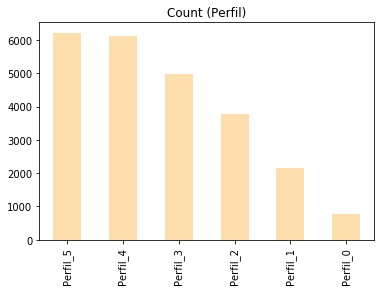

In [7]:
countTargets(df_training_dataset).plot(kind='bar', title='Count (Perfil)', color='navajowhite');

In [8]:
print("Cols: ", len(df_training_dataset.columns), " Rows: ", len(df_training_dataset))

Cols:  16  Rows:  23999


In [9]:
a = df_training_dataset.isna().sum(axis = 1)

In [10]:
Counter(a[a>=2])

Counter({2: 2257, 3: 347, 4: 45, 5: 5})

In [11]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 23999 non-null  int64  
 1   Genero                             23110 non-null  object 
 2   Años                               23731 non-null  float64
 3   Estado_civil                       23295 non-null  object 
 4   Trabajo                            21044 non-null  object 
 5   Sector                             23640 non-null  object 
 6   Telefono                           22578 non-null  object 
 7   Anos_usando_internet_banking       23355 non-null  float64
 8   Anos_usando_banca_movil            22698 non-null  float64
 9   Banca_movil_userfriendly           23999 non-null  object 
 10  Frecuencia_internet_banking_mes    21275 non-null  float64
 11  Frecuencia_banca_movil_mes         22728 non-null  flo

In [81]:
df_training_dataset_1 = df_training_dataset.dropna(thresh=14, inplace=False)

In [82]:
df_training_dataset_1.reset_index(drop=True, inplace=True)

In [83]:
print("Cols: ", len(df_training_dataset_1.columns), " Rows: ", len(df_training_dataset_1))

Cols:  16  Rows:  23602


Perfil  0 : 771 	Proportion: 0.0327 : 1 	Weight: 3.27 %
Perfil  1 : 2132 	Proportion: 0.0903 : 1 	Weight: 9.03 %
Perfil  2 : 3754 	Proportion: 0.1591 : 1 	Weight: 15.91 %
Perfil  3 : 4965 	Proportion: 0.2104 : 1 	Weight: 21.04 %
Perfil  4 : 6109 	Proportion: 0.2588 : 1 	Weight: 25.88 %
Perfil  5 : 5871 	Proportion: 0.2488 : 1 	Weight: 24.88 %


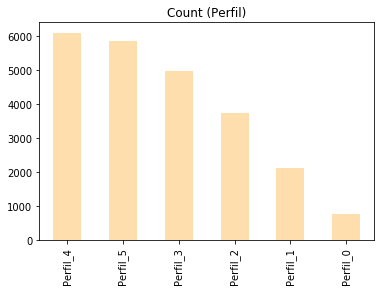

In [84]:
countTargets(df_training_dataset_1).plot(kind='bar', title='Count (Perfil)', color='navajowhite');

In [85]:
for feature in ['Años', 'Anos_usando_internet_banking', 'Anos_usando_banca_movil',]:
    df_training_dataset_1.loc[:, (feature)].fillna(df_training_dataset_1[feature].mean(), inplace=True)
    
for feature in  ['Frecuencia_internet_banking_mes', 'Frecuencia_banca_movil_mes',
               'Frecuencia_pagamentos_tarjeta_mes', 'Frecuencia_tarjeta_virtual_mes', 'Frecuencia_saldo_cuenta_mes']:
    df_training_dataset_1.loc[:, (feature)].fillna(df_training_dataset_1[feature].mean(), inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [86]:
for feature in ['Genero', 'Estado_civil', 'Trabajo', 'Sector', 'Telefono']:
    df_training_dataset_1[feature].fillna(df_training_dataset_1[feature].value_counts().idxmax(), inplace=True)

In [87]:
# # Mostrando los datos nulos del dataset despues de la primera transformación (df)
print("Valores nulos del df_training_dataset despues de la transformación DropNA: \n\n{}\n".format(df_training_dataset_1.isnull().sum(axis = 0)))

Valores nulos del df_training_dataset despues de la transformación DropNA: 

ID                                   0
Genero                               0
Años                                 0
Estado_civil                         0
Trabajo                              0
Sector                               0
Telefono                             0
Anos_usando_internet_banking         0
Anos_usando_banca_movil              0
Banca_movil_userfriendly             0
Frecuencia_internet_banking_mes      0
Frecuencia_banca_movil_mes           0
Frecuencia_pagamentos_tarjeta_mes    0
Frecuencia_tarjeta_virtual_mes       0
Frecuencia_saldo_cuenta_mes          0
TARGET                               0
dtype: int64



In [ ]:
len(df_training_dataset_1)

In [ ]:
Counter(df_training_dataset_1['Genero'])

In [ ]:
Counter(df_training_dataset_1['Sector'])

In [ ]:
Counter(df_training_dataset_1['Estado_civil'])

In [ ]:
Counter(df_training_dataset_1['Trabajo'])

## Pre-procesando el dataset antes del entrenamiento

#### Eliminando colunas no desadas

In [88]:
df_training = df_training_dataset_1.drop(columns=['ID'], inplace=False)

In [89]:
df_training.tail()

Genero  Años Estado_civil           Trabajo               Sector  \
23597      F  40.0      Soltero          Profesor       Sector privado   
23598      F  24.0       Casado          Profesor  Institucion publica   
23599      F  24.0       Casado          Profesor         Desempleados   
23600      F  24.0      Soltero      Desempleados         Desempleados   
23601      M  30.0       Casado  Servidor publico  Institucion publica   

        Telefono  Anos_usando_internet_banking  Anos_usando_banca_movil  \
23597  Iphone 6+                          10.0                      3.0   
23598        L G                          15.0                      6.0   
23599     LG V10                           5.0                      3.0   
23600    Android                           5.0                      6.0   
23601          0                           5.0                      4.0   

      Banca_movil_userfriendly  Frecuencia_internet_banking_mes  \
23597                       Si                             31.0   
23598                       Si                             30.0   
23599                       Si                              0.0   
23600                       No                              7.0   
23601                       No                             31.0   

       Frecuencia_banca_movil_mes  Frecuencia_pagamentos_tarjeta_mes  \
23597                         0.0                                0.0   
23598                        30.0                               31.0   
23599                        30.0                                1.0   
23600                         0.0                                1.0   
23601                        31.0                                0.0   

       Frecuencia_tarjeta_virtual_mes  Frecuencia_saldo_cuenta_mes    TARGET  
23597                             0.0                         31.0  Perfil_3  
23598                            30.0                          7.0  Perfil_0  
23599                             0.0                          0.0  Perfil_4  
23600                             1.0                          0.0  Perfil_4  
23601                             0.0                          0.0  Perfil_3

In [90]:
print("Cols: ", len(df_training.columns), " Rows: ", len(df_training))

Cols:  15  Rows:  23602


#### Label enconder

In [91]:
le_bmuf = LabelEncoder()
target_label_bmuf = pd.DataFrame(le_bmuf.fit_transform(df_training['Banca_movil_userfriendly']))
df_training.drop(columns=['Banca_movil_userfriendly'], inplace=True)
df_training['Banca_movil_userfriendly'] = target_label_bmuf

In [92]:
le_sector = LabelEncoder()
target_label_sector = pd.DataFrame(le_sector.fit_transform(df_training['Sector']))
df_training.drop(columns=['Sector'], inplace=True)
df_training['Sector'] = target_label_sector

In [93]:
le_telefono = LabelEncoder()
target_label_telefono = pd.DataFrame(le_telefono.fit_transform(df_training['Telefono']))
df_training.drop(columns=['Telefono'], inplace=True)
df_training['Telefono'] = target_label_telefono

In [94]:
le_trabajo = LabelEncoder()
target_label_trabajo = pd.DataFrame(le_trabajo.fit_transform(df_training['Trabajo']))
df_training.drop(columns=['Trabajo'], inplace=True)
df_training['Trabajo'] = target_label_trabajo

In [95]:
le_gen = LabelEncoder()
target_label_gen = pd.DataFrame(le_gen.fit_transform(df_training['Genero']))
df_training.drop(columns=['Genero'], inplace=True)
df_training['Genero'] = target_label_gen

In [96]:
le_ecivil = LabelEncoder()
target_label_ecivil = pd.DataFrame(le_ecivil.fit_transform(df_training['Estado_civil']))
df_training.drop(columns=['Estado_civil'], inplace=True)
df_training['Estado_civil'] = target_label_ecivil

In [97]:
le_target = LabelEncoder()
target_label_target = pd.DataFrame(le_target.fit_transform(df_training['TARGET']))
df_training.drop(columns=['TARGET'], inplace=True)
df_training['TARGET'] = target_label_target

In [98]:
df_training.tail()

Años  Anos_usando_internet_banking  Anos_usando_banca_movil  \
23597  40.0                          10.0                      3.0   
23598  24.0                          15.0                      6.0   
23599  24.0                           5.0                      3.0   
23600  24.0                           5.0                      6.0   
23601  30.0                           5.0                      4.0   

       Frecuencia_internet_banking_mes  Frecuencia_banca_movil_mes  \
23597                             31.0                         0.0   
23598                             30.0                        30.0   
23599                              0.0                        30.0   
23600                              7.0                         0.0   
23601                             31.0                        31.0   

       Frecuencia_pagamentos_tarjeta_mes  Frecuencia_tarjeta_virtual_mes  \
23597                                0.0                             0.0   
23598                               31.0                            30.0   
23599                                1.0                             0.0   
23600                                1.0                             1.0   
23601                                0.0                             0.0   

       Frecuencia_saldo_cuenta_mes  Banca_movil_userfriendly  Sector  \
23597                         31.0                         1       2   
23598                          7.0                         1       1   
23599                          0.0                         1       0   
23600                          0.0                         0       0   
23601                          0.0                         0       1   

       Telefono  Trabajo  Genero  Estado_civil  TARGET  
23597        24       22       1             1       3  
23598        31       22       1             0       0  
23599        36       22       1             0       4  
23600         2        5       1             1       4  
23601         0       26       2             0       3

#### Correlaciones de features

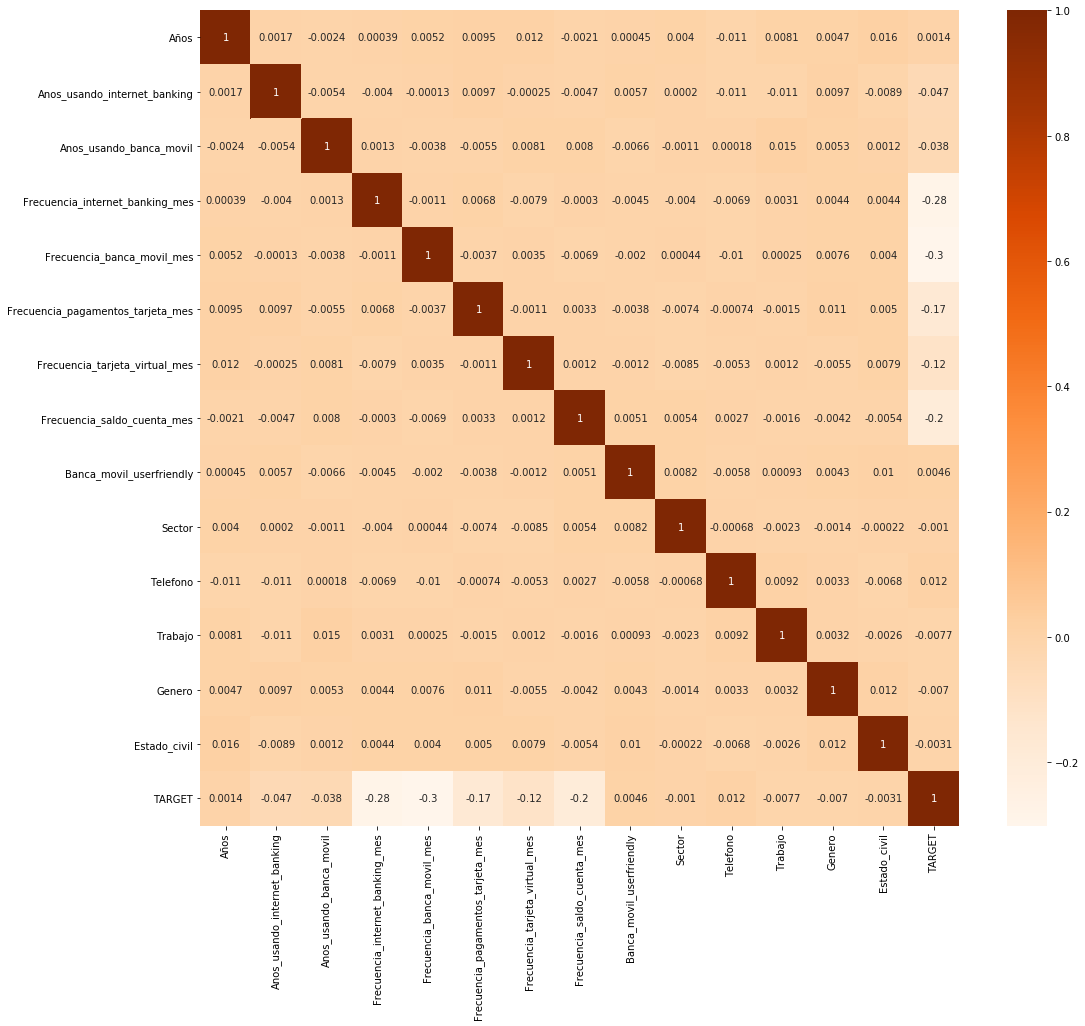

In [99]:
#Using Pearson Correlation
plt.figure(figsize=(17,15))
cor = df_training.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Oranges)
plt.show()

In [100]:
#Correlation with output variable
cor_target = abs(cor["TARGET"])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.0]
relevant_features

Años                                 0.001367
Anos_usando_internet_banking         0.046880
Anos_usando_banca_movil              0.037713
Frecuencia_internet_banking_mes      0.282197
Frecuencia_banca_movil_mes           0.301318
Frecuencia_pagamentos_tarjeta_mes    0.170373
Frecuencia_tarjeta_virtual_mes       0.117304
Frecuencia_saldo_cuenta_mes          0.196014
Banca_movil_userfriendly             0.004646
Sector                               0.001048
Telefono                             0.011743
Trabajo                              0.007661
Genero                               0.006965
Estado_civil                         0.003133
TARGET                               1.000000
Name: TARGET, dtype: float64

In [101]:
df_training_dataset_2 = df_training.drop(columns=['Años', 'Banca_movil_userfriendly', 'Sector', 'Telefono', 'Genero', 'Estado_civil'], inplace=False)

In [102]:
target_label = pd.DataFrame(le_target.inverse_transform(df_training_dataset_2['TARGET']))
df_training_dataset_2.drop(columns=['TARGET'], inplace=True)
df_training_dataset_2['TARGET'] = target_label

In [103]:
df_training_dataset_2.head()

Anos_usando_internet_banking  Anos_usando_banca_movil  \
0                           0.0                      6.0   
1                           5.0                      3.0   
2                           0.0                      3.0   
3                           5.0                      3.0   
4                           6.0                      0.0   

   Frecuencia_internet_banking_mes  Frecuencia_banca_movil_mes  \
0                             50.0                    0.000000   
1                             31.0                    4.000000   
2                             50.0                   31.000000   
3                             30.0                    7.000000   
4                              4.0                   17.378119   

   Frecuencia_pagamentos_tarjeta_mes  Frecuencia_tarjeta_virtual_mes  \
0                                1.0                             0.0   
1                               31.0                             0.0   
2                               15.0                             1.0   
3                               30.0                             0.0   
4                                1.0                            15.0   

   Frecuencia_saldo_cuenta_mes  Trabajo    TARGET  
0                         30.0       22  Perfil_2  
1                         30.0       22  Perfil_1  
2                         15.0       26  Perfil_4  
3                         31.0       13  Perfil_1  
4                          1.0       11  Perfil_3

#### Tratamiento de variables categóricas

In [ ]:
df_training_dataset_2 = pd.get_dummies(df_training_dataset_2, columns=['Genero'])
df_training_dataset_2.tail()

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
ohenc = pd.DataFrame(enc.fit_transform(df_training_dataset_rmcolumns[['Banca_movil_userfriendly']]).toarray()).add_prefix('bmuf_')
df_training = df_training_dataset_rmcolumns.drop(columns=['Banca_movil_userfriendly'], inplace=False)
df_training['Banca_movil_userfriendly'] = ohenc
df_training.tail()

<hr>

## Entrenando un clasificador con base en un árbol de decisión

### Selecionando FEATURES y definiendo la variable TARGET

In [104]:
len(df_training_dataset_2.columns)

9

In [105]:
features_columns = np.array(df_training_dataset_2.columns)
features_columns = np.delete(features_columns, np.where(features_columns == 'TARGET'))
len(features_columns)

8

In [106]:
features = df_training_dataset_2[
    features_columns
]
target = df_training_dataset_2['TARGET']  ## No cambie esta variable

# Numero de variables independientes
iv = 7

### GridSearch and crossValidation

In [107]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.99, random_state=0)

In [108]:
X_train.head()

Anos_usando_internet_banking  Anos_usando_banca_movil  \
16905                          10.0                      3.0   
3502                           10.0                      3.0   
7411                            0.0                      3.0   
14969                           5.0                      3.0   
10349                          10.0                      3.0   

       Frecuencia_internet_banking_mes  Frecuencia_banca_movil_mes  \
16905                             31.0                        50.0   
3502                              31.0                        31.0   
7411                               4.0                         1.0   
14969                             31.0                         7.0   
10349                              4.0                         0.0   

       Frecuencia_pagamentos_tarjeta_mes  Frecuencia_tarjeta_virtual_mes  \
16905                                1.0                             0.0   
3502                                 1.0                             0.0   
7411                                15.0                             0.0   
14969                                1.0                            15.0   
10349                                1.0                             1.0   

       Frecuencia_saldo_cuenta_mes  Trabajo  
16905                     4.000000       15  
3502                     31.000000       11  
7411                      0.000000       11  
14969                     0.000000       22  
10349                    10.510941       22

In [109]:
print('Distribucion: %s' % Counter(y_train))

Distribucion: Counter({'Perfil_4': 6042, 'Perfil_5': 5820, 'Perfil_3': 4918, 'Perfil_2': 3709, 'Perfil_1': 2112, 'Perfil_0': 764})


In [110]:
sc = StandardScaler()
X_train.iloc[:, :iv] = sc.fit_transform(X_train.iloc[:, :iv])
X_test.iloc[:, :iv] = sc.transform(X_test.iloc[:, :iv])

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


#### RFC

In [ ]:
clf = RandomForestClassifier()

parameters = {'n_estimators': [30, 60, 90],
              'max_features': ['log2', 'sqrt','auto'],
              'criterion': ['entropy', 'gini'],
              'max_depth': [15, 50, 75],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

#### ETC

In [ ]:
clf = ExtraTreesClassifier()

parameters = {'n_estimators': [30, 60, 90],
              'max_features': ['log2', 'sqrt','auto'],
              'criterion': ['entropy', 'gini'],
              'max_depth': [15, 50, 75],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

#### DTC

In [ ]:
clf = DecisionTreeClassifier()

parameters = {'max_features': ['log2', 'sqrt','auto'],
              'criterion': ['entropy', 'gini'],
              'max_depth': [5, 15, 20, 50],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8],
              'splitter': ['best', 'random']
             }

#### SVC

In [ ]:
clf = SVC()

parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
             }

In [ ]:
clf = XGBClassifier()

parameters = {'booster': ['gbtree', 'dart']
             }

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(20, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X=X_train, y=y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#### GridSearch

In [ ]:
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

#### Cross Validation

In [ ]:
classifier = SVC(C=1000, gamma=0.01)
all_accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)

In [111]:
#classifier = RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=90)
classifier = RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=5, n_estimators=100)
all_accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)

In [112]:
print(all_accuracies)

[0.86692341 0.8703466  0.86649551 0.85836543 0.86435601 0.87585616
 0.86943493 0.86258562 0.86044521 0.8510274 ]


In [113]:
print(all_accuracies.mean())

0.8645836264148512


#### Cross Validation KFold

In [114]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)  

classifier = RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=5, n_estimators=100)
all_accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=skf)

In [115]:
print(all_accuracies)

[0.85579803 0.86521181 0.86221652 0.8677792  0.86178862 0.87628425
 0.85958904 0.86857877 0.86643836 0.85873288]


In [116]:
print(all_accuracies.mean())

0.8642417468244619


<hr>

####  Entrenar el modelo

In [117]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.85, random_state=33, stratify=target, shuffle=True)

In [118]:
print('Distribucion de clases:', Counter(y_train))

Distribucion de clases: Counter({'Perfil_4': 5193, 'Perfil_5': 4990, 'Perfil_3': 4220, 'Perfil_2': 3191, 'Perfil_1': 1812, 'Perfil_0': 655})


In [119]:
sc = StandardScaler()
X_train.iloc[:, :iv] = sc.fit_transform(X_train.iloc[:, :iv])
X_test.iloc[:, :iv] = sc.transform(X_test.iloc[:, :iv])

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


1. ExtraTreesClassifier(max_depth=15, min_samples_split=3, n_estimators=90)
0.8496897071753396
0.8496897071753396

2. RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=5)
0.8502237089570924
0.8509845057382919

3. ExtraTreesClassifier(max_depth=15, max_features='log2', min_samples_split=5, n_estimators=90)

In [120]:
dtc = RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=5, n_estimators=100)
dtc.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=5)

#### Feature importance

<BarContainer object of 8 artists>

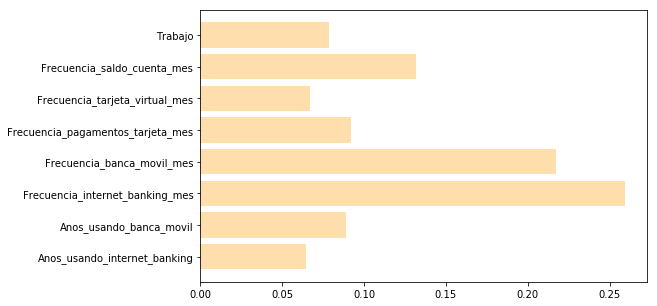

In [121]:
plt.rcParams.update({'figure.figsize': (8.0, 5.0)})
plt.rcParams.update({'font.size': 10})

plt.barh(features_columns, dtc.feature_importances_, color='navajowhite')

#### Haciendo predicciones en la muestra de prueba

In [122]:
y_pred = dtc.predict(X_test)
print(y_pred)

['Perfil_5' 'Perfil_1' 'Perfil_5' ... 'Perfil_5' 'Perfil_3' 'Perfil_3']


#### Analizando la calidad del modelo a través de la matriz de confusión

In [123]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Oranges')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

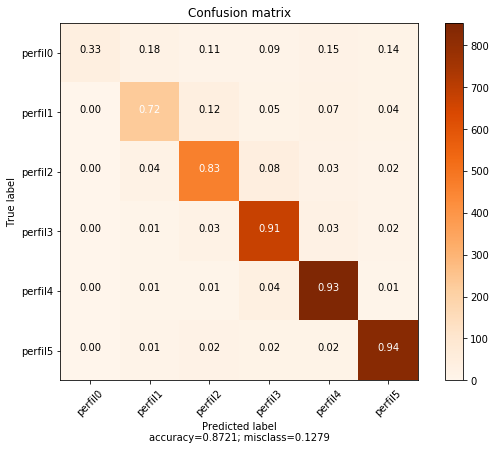

In [124]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['perfil0', 'perfil1', 'perfil2', 'perfil3', 'perfil4', 'perfil5'])

In [125]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 38  21  13  11  17  16]
 [  1 229  38  15  23  14]
 [  1  23 466  44  17  12]
 [  0  10  22 676  24  13]
 [  0   9  10  35 854   8]
 [  0  11  17  14  14 825]]
              precision    recall  f1-score   support

    Perfil_0       0.95      0.33      0.49       116
    Perfil_1       0.76      0.72      0.74       320
    Perfil_2       0.82      0.83      0.83       563
    Perfil_3       0.85      0.91      0.88       745
    Perfil_4       0.90      0.93      0.92       916
    Perfil_5       0.93      0.94      0.93       881

    accuracy                           0.87      3541
   macro avg       0.87      0.77      0.80      3541
weighted avg       0.87      0.87      0.87      3541

0.872070036712793


<hr>

## Scoring de los datos necesarios para entregar la solución

Como entrega de su solución, esperamos los resultados clasificados del seguiente dataset llamado "to_be_scored.csv":

### Download la "Hoja de evaluación"

In [126]:
!wget --no-check-certificate --content-disposition https://gitlab.com/JoaoPedroPP/datasets/-/raw/master/to_be_scored.csv
df_to_be_scored = pd.read_csv(r'to_be_scored.csv')
df_to_be_scored.tail()

--2020-09-17 14:40:30--  https://gitlab.com/JoaoPedroPP/datasets/-/raw/master/to_be_scored.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘to_be_scored.csv.1’

    [ <=>                                   ] 87,631      --.-K/s   in 0.002s  

2020-09-17 14:40:30 (41.7 MB/s) - ‘to_be_scored.csv.1’ saved [87631]



ID Genero  Años Estado_civil           Trabajo               Sector  \
995   25      M  35.0       Casado      Desempleados       Sector privado   
996  179      M  40.0      Soltero          Profesor       Sector privado   
997  222      M  30.0       Casado          Profesor  Institucion publica   
998  238      F  35.0       Casado  Servidor publico         Desempleados   
999  152      M  35.0      Soltero          Profesor  Institucion publica   

     Telefono  Anos_usando_internet_banking  Anos_usando_banca_movil  \
995      ASUS                           5.0                      3.0   
996   Iphone                           10.0                      NaN   
997     LG G2                           5.0                      3.0   
998  Iphone 5                          15.0                      4.0   
999    Iphone                           0.0                      NaN   

    Banca_movil_userfriendly  Frecuencia_internet_banking_mes  \
995                       No                              7.0   
996                       Si                              0.0   
997                       Si                             31.0   
998                       No                              0.0   
999                       Si                             30.0   

     Frecuencia_banca_movil_mes  Frecuencia_pagamentos_tarjeta_mes  \
995                        50.0                                1.0   
996                         1.0                                0.0   
997                        31.0                                0.0   
998                         4.0                                1.0   
999                         7.0                               15.0   

     Frecuencia_tarjeta_virtual_mes  Frecuencia_saldo_cuenta_mes  
995                             0.0                         31.0  
996                            15.0                          1.0  
997                             0.0                          NaN  
998                             0.0                         31.0  
999                            15.0                         15.0

#### Preprocesamiento

In [127]:
print("Cols: ", len(df_to_be_scored.columns), " Rows: ", len(df_to_be_scored))

Cols:  15  Rows:  1000


In [128]:
print("Valores nulos del df_training_dataset antes de la transformación DropNA: \n\n{}\n".format(df_to_be_scored.isnull().sum(axis = 0)))

Valores nulos del df_training_dataset despues de la transformación DropNA: 

ID                                     0
Genero                                37
Años                                  20
Estado_civil                          24
Trabajo                              136
Sector                                17
Telefono                              73
Anos_usando_internet_banking          23
Anos_usando_banca_movil               55
Banca_movil_userfriendly               0
Frecuencia_internet_banking_mes       89
Frecuencia_banca_movil_mes            60
Frecuencia_pagamentos_tarjeta_mes      9
Frecuencia_tarjeta_virtual_mes        23
Frecuencia_saldo_cuenta_mes           27
dtype: int64



#### Valores NaN

In [129]:
a = df_to_be_scored.isna().sum(axis = 1)
Counter(a[a>=0])

Counter({0: 533, 1: 362, 2: 85, 3: 19, 4: 1})

In [130]:
for feature in ['Años', 'Anos_usando_internet_banking', 'Anos_usando_banca_movil',]:
    df_to_be_scored.loc[:, (feature)].fillna(df_to_be_scored[feature].mean(), inplace=True)
    
for feature in  ['Frecuencia_internet_banking_mes', 'Frecuencia_banca_movil_mes',
               'Frecuencia_pagamentos_tarjeta_mes', 'Frecuencia_tarjeta_virtual_mes', 'Frecuencia_saldo_cuenta_mes']:
    df_to_be_scored.loc[:, (feature)].fillna(df_to_be_scored[feature].mean(), inplace=True)

In [131]:
for feature in ['Genero', 'Estado_civil', 'Trabajo', 'Sector', 'Telefono']:
    df_to_be_scored[feature].fillna(df_to_be_scored[feature].value_counts().idxmax(), inplace=True)

In [132]:
print("Valores nulos del df_training_dataset despues de la transformación DropNA: \n\n{}\n".format(df_to_be_scored.isnull().sum(axis = 0)))

Valores nulos del df_training_dataset despues de la transformación DropNA: 

ID                                   0
Genero                               0
Años                                 0
Estado_civil                         0
Trabajo                              0
Sector                               0
Telefono                             0
Anos_usando_internet_banking         0
Anos_usando_banca_movil              0
Banca_movil_userfriendly             0
Frecuencia_internet_banking_mes      0
Frecuencia_banca_movil_mes           0
Frecuencia_pagamentos_tarjeta_mes    0
Frecuencia_tarjeta_virtual_mes       0
Frecuencia_saldo_cuenta_mes          0
dtype: int64



In [133]:
print("Cols: ", len(df_to_be_scored.columns), " Rows: ", len(df_to_be_scored))

Cols:  15  Rows:  1000


In [ ]:
Counter(df_to_be_scored['Sector'])

In [ ]:
Counter(df_to_be_scored['Genero'])

#### Label encoding

In [135]:
le_trabajo = LabelEncoder()
target_label_trabajo = pd.DataFrame(le_trabajo.fit_transform(df_to_be_scored['Trabajo']))
df_to_be_scored.drop(columns=['Trabajo'], inplace=True)
df_to_be_scored['Trabajo'] = target_label_trabajo

<hr>

# ¡Atención!

# Para poder aplicar su modelo y clasificar la hoja de evaluación, usted debe aplicar primero todas las transformaciones de columna que usted aplico en el dataset de entrenamiento.

# No remueva o adicione filas en la hoja de evaluación. 

# No altere el orden de las filas en la hoja de evaluación. 

# Al final, las 1000 entradas deben estar clasificadas, con los valores calculados en una columna llamada "target"

<hr>

En la celda de abajo, repetimos rapidamente los mismos pasos de pré-procesamiento usados en el ejemplo dado con árbol de decisión

#### Eliminar columnas

In [137]:
# 3 - Remoción de columnas
df_to_be_scored_2 = df_to_be_scored.drop(columns=['ID', 'Años', 'Banca_movil_userfriendly', 'Sector', 'Telefono', 'Genero', 'Estado_civil'], inplace=False)
df_to_be_scored_2.head()

Anos_usando_internet_banking  Anos_usando_banca_movil  \
0                          10.0                      3.0   
1                          10.0                      3.0   
2                          10.0                      6.0   
3                          10.0                      6.0   
4                           5.0                      6.0   

   Frecuencia_internet_banking_mes  Frecuencia_banca_movil_mes  \
0                         31.00000                         7.0   
1                          0.00000                         7.0   
2                          1.00000                         1.0   
3                         16.15258                        50.0   
4                          4.00000                         7.0   

   Frecuencia_pagamentos_tarjeta_mes  Frecuencia_tarjeta_virtual_mes  \
0                                0.0                             0.0   
1                                1.0                             0.0   
2                               15.0                             0.0   
3                               15.0                             0.0   
4                                0.0                             0.0   

   Frecuencia_saldo_cuenta_mes  Trabajo  
0                         31.0       10  
1                          0.0       10  
2                          4.0        5  
3                          0.0       10  
4                         15.0       26

#### Scaler

In [138]:
sc = StandardScaler()
df_to_be_scored_2.iloc[:, :iv] = sc.fit_transform(df_to_be_scored_2.iloc[:, :iv])
df_to_be_scored_2.head()

Anos_usando_internet_banking  Anos_usando_banca_movil  \
0                      1.113060                -0.333820   
1                      1.113060                -0.333820   
2                      1.113060                 1.233032   
3                      1.113060                 1.233032   
4                     -0.339598                 1.233032   

   Frecuencia_internet_banking_mes  Frecuencia_banca_movil_mes  \
0                     9.207912e-01                   -0.609819   
1                    -1.001733e+00                   -0.609819   
2                    -9.397162e-01                   -0.946946   
3                     2.203283e-16                    1.806263   
4                    -7.536655e-01                   -0.609819   

   Frecuencia_pagamentos_tarjeta_mes  Frecuencia_tarjeta_virtual_mes  \
0                          -0.594348                       -0.452422   
1                          -0.497201                       -0.452422   
2                           0.862848                       -0.452422   
3                           0.862848                       -0.452422   
4                          -0.594348                       -0.452422   

   Frecuencia_saldo_cuenta_mes  Trabajo  
0                     1.692156       10  
1                    -0.871405       10  
2                    -0.540623        5  
3                    -0.871405       10  
4                     0.369028       26

#### Categoticas

In [139]:
print("Cols: ", len(df_to_be_scored_2.columns), " Rows: ", len(df_to_be_scored_2))

Cols:  8  Rows:  1000


# Atención

Para todas las columnas que no existiren en "df_to_be_scored", usted puede usar la tecnica de abajo para adicionarla:

In [140]:
y_pred = dtc.predict(df_to_be_scored_2)
df_to_be_scored_2['TARGET'] = y_pred
df_to_be_scored_2.tail()

Anos_usando_internet_banking  Anos_usando_banca_movil  \
995                     -0.339598                -0.333820   
996                      1.113060                 0.000000   
997                     -0.339598                -0.333820   
998                      2.565718                 0.188464   
999                     -1.792256                 0.000000   

     Frecuencia_internet_banking_mes  Frecuencia_banca_movil_mes  \
995                        -0.567615                    1.806263   
996                        -1.001733                   -0.946946   
997                         0.920791                    0.738692   
998                        -1.001733                   -0.778383   
999                         0.858774                   -0.609819   

     Frecuencia_pagamentos_tarjeta_mes  Frecuencia_tarjeta_virtual_mes  \
995                          -0.497201                       -0.452422   
996                          -0.594348                        1.812778   
997                          -0.594348                       -0.452422   
998                          -0.497201                       -0.452422   
999                           0.862848                        1.812778   

     Frecuencia_saldo_cuenta_mes  Trabajo    TARGET  
995                 1.692156e+00        5  Perfil_2  
996                -7.887095e-01       22  Perfil_5  
997                 1.468967e-16       22  Perfil_5  
998                 1.692156e+00       26  Perfil_3  
999                 3.690277e-01       22  Perfil_5

### Guardando la hoja de evaluacion como un archivo .csv para ser enviado
**SI YA TIENE UN DATA ASSET CON EL NOMBRE results.csv EN ESTE PROYECTO O EN OTRO PROYECTO DE WATSON STUDIO DEBE BORRAR EL ARCHIVO ANTES DE CORRER LA SIGUIENTE CELDA O TENDRA EL ERROR: _RuntimeError: File 'results.csv' already exists in storage._**

In [142]:
Counter(y_pred)

Counter({'Perfil_2': 162,
         'Perfil_4': 277,
         'Perfil_5': 256,
         'Perfil_3': 227,
         'Perfil_1': 63,
         'Perfil_0': 15})

Perfil  0 : 15 	Proportion: 0.015 : 1 	Weight: 1.5 %
Perfil  1 : 63 	Proportion: 0.063 : 1 	Weight: 6.3 %
Perfil  2 : 162 	Proportion: 0.162 : 1 	Weight: 16.2 %
Perfil  3 : 227 	Proportion: 0.227 : 1 	Weight: 22.7 %
Perfil  4 : 277 	Proportion: 0.277 : 1 	Weight: 27.7 %
Perfil  5 : 256 	Proportion: 0.256 : 1 	Weight: 25.6 %


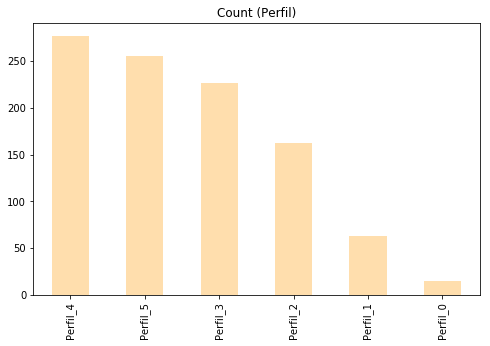

In [141]:
countTargets(df_to_be_scored_2).plot(kind='bar', title='Count (Perfil)', color='navajowhite');

In [143]:
project.save_data(file_name="results.csv", data=df_to_be_scored_2.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'bancoppel-donotdelete-pr-3tfmqyslomehrq',
 'asset_id': 'a962f7a9-39fa-4d59-b7ed-016d6b66bffc'}

# ATENCIÓN

# La ejecución de la celda anterior creará un nuevo "data asset" en su proyecto de Watson Studio. Deberá descargar este archivo junto con este cuaderno y crear un archivo zip con results.csv y notebook.ipynb para enviarlo. (los archivos deben tener este nombre)

<hr>

## ¡Felicitaciones!
Si ya está satisfecho con su solución, vaya a la página siguiente y envíe los archivos necesarios para su envío.

# https://bancoppel.maratona.dev
